# Week 4: Tongue Rolling Example Continued

<font color="red">As almost all results are based on our posterior simulation, numerical values might differ from the ones given on the slides!</font>

Load necessary modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
from scipy import stats

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,3)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Uninformed prior and data collected in lecture:

In [2]:
n = 28
k = 26
alpha = 1
beta = 1

## Part 1: Sampling from the Posterior

In [3]:
with pm.Model() as tongue_rolling_model:
    pi = pm.Beta( 'pi', alpha=1, beta=1 )
    y = pm.Binomial( 'y', n=n, p=pi, observed=k )
    trace = pm.sample( 1000 )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'pi'}>, <Axes: title={'center': 'pi'}>]],
      dtype=object)

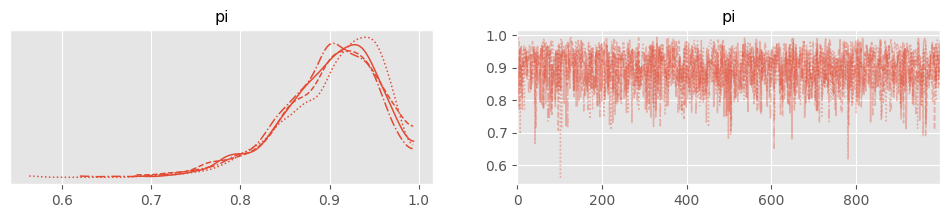

In [4]:
pm.plot_trace( trace )

Looks all good at first sight.

## Part 2: Estimation

Summary:

In [5]:
pm.summary( trace )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi,0.9,0.055,0.801,0.992,0.001,0.001,1754.0,1805.0,1.0


HDI:

In [6]:
pm.hdi( trace, hdi_prob=0.8 ).pi.values

array([0.84341573, 0.97220017])

## Part 3: Prediction

Sample with PyMC:

In [7]:
with tongue_rolling_model:
    y_new = pm.Binomial('y_new', n=40, p=pi)
    predictions = pm.sample_posterior_predictive(trace, var_names=["y_new"])

Sampling: [y_new]


Visualize predictions with density plot:

<Axes: ylabel='Density'>

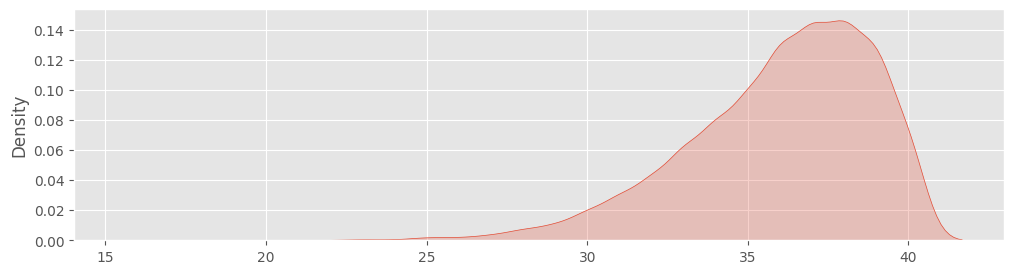

In [8]:
sns.kdeplot( predictions.posterior_predictive.y_new.values.flatten(), fill=True )

Alternatively with pymc as histogram (since the binomial distribution is discrete!)

<Axes: title={'center': 'y_new'}>

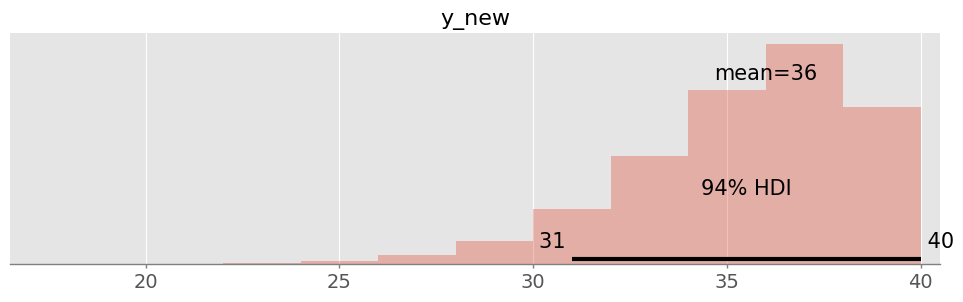

In [9]:
pm.plot_posterior( predictions.posterior_predictive.y_new )

Summary:

In [10]:
pm.summary( predictions, group="posterior_predictive", hdi_prob=0.95 )

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y_new,36.009,2.91,31.0,40.0,0.058,0.041,2385.0,3476.0,1.0


### Decomposition into aleatoric and epistemic uncertainty

Aleatoric uncertainty:

In [11]:
n_new = 40
aleatoric_vars = n_new * trace.posterior.pi.values * (1-trace.posterior.pi.values)
aleatoric_var = np.mean( aleatoric_vars )
aleatoric_var

3.4866594775780855

Epistemic uncertainty:

In [12]:
epistemic_var = np.var( trace.posterior.pi.values * n_new )
epistemic_var

4.771754214020255

Total predictive uncertainty as simulated with PyMC:

In [13]:
pred_var = np.var( predictions.posterior_predictive.y_new.values )
pred_var

8.463173437499998

Check: Aleatoric variance + epistemic variance should return more or less predictive variance

In [14]:
aleatoric_var + epistemic_var

8.25841369159834

(ok)

Compute proportions in %:

In [15]:
np.round( np.array( [aleatoric_var, epistemic_var] ) / (aleatoric_var + epistemic_var) * 100, 1 )

array([42.2, 57.8])

## Part 4: Hypothesis Tests

Hypotheses to test:

* $H_0$: $\pi \leq 0.8$
* $H_1$: $\pi > 0.8$

### Frequentist One-Sided Test

Maximum likelihood estimator (that you derived in exercise sheet 1):

In [16]:
pihat = k/n
pihat

0.9285714285714286

z-score:

In [17]:
pi0 = 0.8
sigma = np.sqrt( pi0 * (1-pi0) / n )
z = (pihat-pi0) / sigma
z

1.7008401285415224

Probability to see this z-score or a more extreme value ($1-\Phi(z)$):

In [18]:
1-stats.norm.cdf(x=z, loc=0, scale=1)

0.04448650585090663

Accept $H_0$!

### Bayesian One-Sided Test

Visualisation:

Text(0, 0.5, '$p(\\pi|Y=23)$')

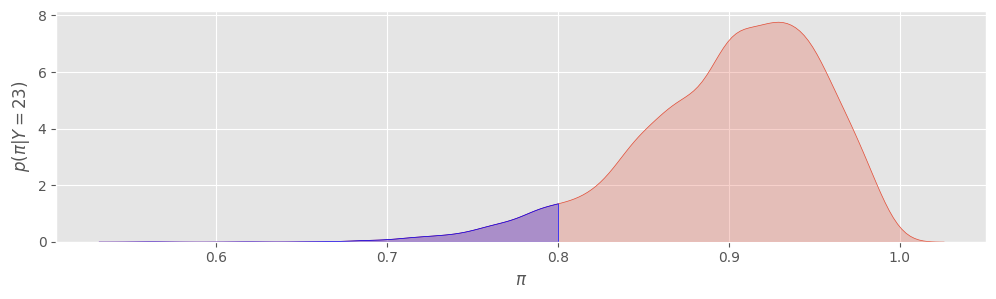

In [19]:
sns.kdeplot( trace.posterior.pi.values.flatten(), fill=True )
sns.kdeplot( trace.posterior.pi.values.flatten(), fill=True, clip=[0, 0.8], color="blue" )
plt.xlabel("$\pi$" )
plt.ylabel("$p(\pi|Y=23)$")

Posterior probabilities:

In [20]:
pH1d = np.mean( trace.posterior.pi > 0.8 ).values
pH1d, 1-pH1d

(array(0.94275), 0.05725000000000002)

Posterior odds:

In [21]:
posterior_odds = pH1d/(1-pH1d)
posterior_odds

16.467248908296938

Prior odds (as we could define them):

In [22]:
prior_odds = np.array([1, 0.2]) # two variants: 1 (uniform) or 0.2 (believed more that pi < 0.8 before)

Bayes factor:

In [23]:
BF = posterior_odds / prior_odds
BF

array([16.46724891, 82.33624454])

### Bayesian Two-Sided Test

In [24]:
pi0 = 0.93; delta = 0.03;
pH0d = np.mean( (trace.posterior.pi.values > pi0 - delta) & (trace.posterior.pi.values < pi0 + delta) )
pH1d = 1-pH0d
pH1d, pH0d

(0.5527500000000001, 0.44725)

Believe more that true value of $\pi$ is outside of ROPE!

Visualisation:

Text(0, 0.5, '$p(\\pi|Y=23)$')

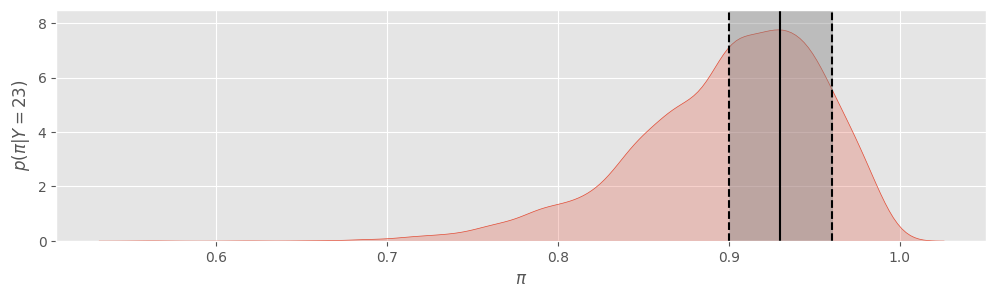

In [25]:
sns.kdeplot( trace.posterior.pi.values.flatten(), fill=True )
plt.axvline( pi0 - delta, c="black", ls="--" )
plt.axvline( pi0, c="black" )
plt.axvline( pi0 + delta, c="black", ls="--" )
plt.ylim([0,8.5])
plt.fill_between( [pi0-delta, pi0+delta], 8.5, color="gray", alpha=0.4 )
plt.xlabel("$\pi$")
plt.ylabel("$p(\pi|Y=23)$")

Posterior odds:

In [26]:
posterior_odds = pH1d / pH0d
posterior_odds

1.2358859698155396